### Classificatore
Il classificatore è un modello semplice con pochi layer densi e un layer finale per la classificazione con la softmax.\
Essendo i dati molto più piccoli le batch possono essere alte e si possono avere molte più epoche per far imparare.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, callbacks, ops, random, saving
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

dataset_path = '../datasets/covid_cxr_cache.npy'
model_save_path = '../models/classifier.keras'
encoder_path = '../models/autoencoder_vae_encoder.keras'

epochs = 100
batch = 1024

# if it is using the vae
@saving.register_keras_serializable()
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

Il dataset viene caricato e modificato in modo da avere in input solo le rappresentazioni latenti delle immagini.\
Di seguito viene caricato l'autoencoder e preso l'encoder in modo da poter creare o caricare il vettore dello spazio latente per ogni immagine.

In [2]:
dataset = np.load(dataset_path, allow_pickle=True).item()

(x_train, y_train) = dataset['train']
(x_val, y_val) = dataset['val']
(x_test, y_test) = dataset['test']

encoder = models.load_model(encoder_path)
latent_space = encoder.output_shape[1]

def data_generator(x, batch_size):
    indices = np.arange(len(x))
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(x), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_data = x[batch_indices].astype('float32') / 255.0
            yield batch_data, batch_data

batch_pred = 32
x_train = encoder.predict(data_generator(x_train, batch_pred), steps=len(x_train) // batch_pred + 1)
x_val = encoder.predict(data_generator(x_val, batch_pred), steps=len(x_val) // batch_pred + 1)
x_test = encoder.predict(data_generator(x_test, batch_pred), steps=len(x_test) // batch_pred + 1)

if encoder_path.find('vae') != -1:
    x_train = x_train[0]
    x_val = x_val[0]
    x_test = x_test[0]
    latent_space = latent_space[1]

2121/2121 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


Purtroppo essendo il dataset molto sbilanciato verso una classe l'addestramento viene influenzato negativamente se non si fanno delle correzioni.

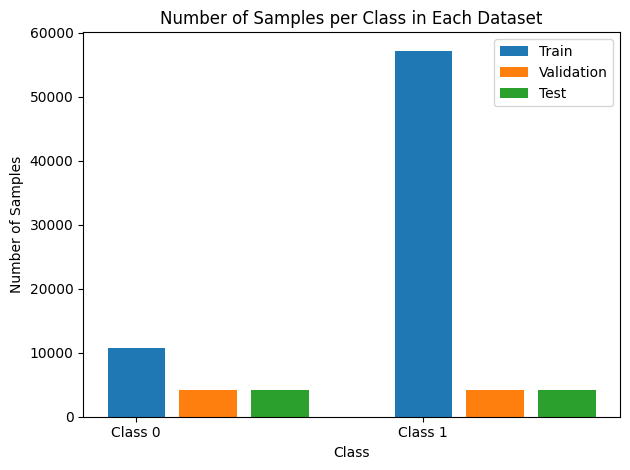

In [3]:
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

total_classes = len(train_counts)
class_weights = {i: len(y_train) / (total_classes * count) for i, count in enumerate(train_counts)}

plt.figure()
x_labels = range(total_classes)
plt.bar(x_labels, train_counts, width=0.2, label='Train', align='center')
plt.bar([x + 0.25 for x in x_labels], val_counts, width=0.2, label='Validation', align='center')
plt.bar([x + 0.5 for x in x_labels], test_counts, width=0.2, label='Test', align='center')
plt.xticks(x_labels, [f"Class {i}" for i in x_labels])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in Each Dataset')
plt.legend()
plt.tight_layout()
plt.show()

La struttura del classificatore.\
Questo modello verrà valutato tramite *sparse_categorical_crossentropy* dato che restituirà un array con le probabilità per ogni classe.

In [4]:
in_classifier = layers.Input(shape=(latent_space,), dtype='float32')
x = layers.BatchNormalization()(in_classifier)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(8)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
out_classifier = layers.Dense(total_classes, activation='softmax')(x)

classifier = models.Model(in_classifier, out_classifier, name='classifier')
classifier.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,834 (202.48 KB)

 Trainable params: 50,922 (198.91 KB)

 Non-trainable params: 912 (3.56 KB)

In questa porzione di codice il modello viene addestrato

In [5]:
history = classifier.fit(x_train, y_train, validation_data=(x_val, y_val),
                         epochs=epochs,
                         batch_size=batch, class_weight=class_weights,
                         callbacks=[callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')])

Training classifier...
Training samples: 67863, (67863, 128), (67863,)
Validation samples: (8473,), (128,), 
Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - accuracy: 0.6463 - loss: 0.7538 - val_accuracy: 0.5028 - val_loss: 0.7003
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5343 - loss: 0.6925 - val_accuracy: 0.4978 - val_loss: 0.6983
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5131 - loss: 0.6884 - val_accuracy: 0.5012 - val_loss: 0.6987
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5524 - loss: 0.6852 - val_accuracy: 0.4938 - val_loss: 0.6999
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5744 - loss: 0.6789 - val_accuracy: 0.4939 - val_loss: 0.7002
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5442 - loss: 0.6805 - val_accuracy: 0.4904 - val_loss: 0.7031
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5666 - loss: 0.6763 - val_accuracy: 0.4959 - val_loss: 0.7042

Di seguito la loss nel tempo

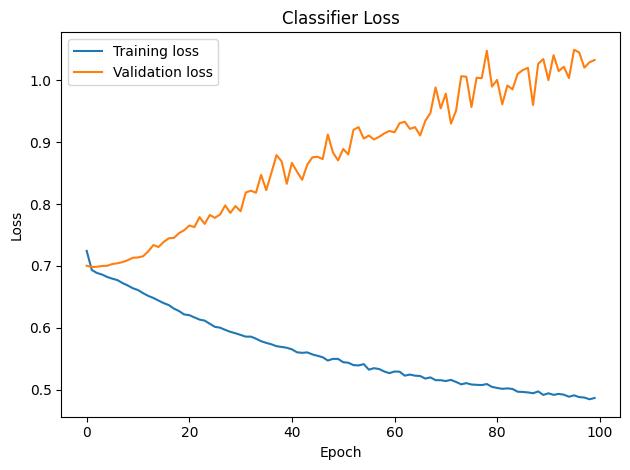

In [6]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Il risultato è che il classificatore riesce a distinguere abbastanza bene nella parte di training mentre fallisce nel generalizzare

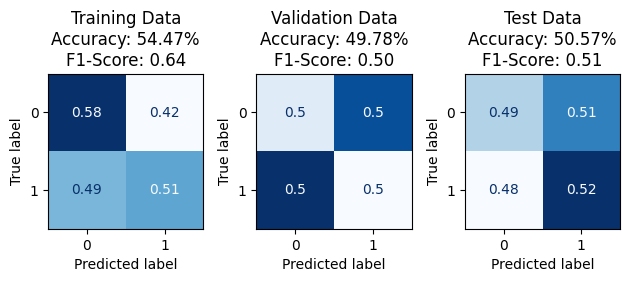

In [7]:
classifier = models.load_model(model_save_path)

y_train_pred = classifier.predict(x_train, verbose=0)
y_val_pred = classifier.predict(x_val, verbose=0)
y_test_pred = classifier.predict(x_test, verbose=0)

datasets = [
    ("Training Data", y_train, y_train_pred),
    ("Validation Data", y_val, y_val_pred),
    ("Test Data", y_test, y_test_pred)
]

_, axes = plt.subplots(1, len(datasets), figsize=None)
for i, (title, y_true, y_pred) in enumerate(datasets):
    y_pred = np.argmax(y_pred, axis=1)
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        normalize='true',
        display_labels=[i for i in range(total_classes)],
        cmap=plt.cm.Blues,
        colorbar=False,
        ax=axes[i]
    )
    axes[i].set_title(f"{title}\n"
                        + f"Accuracy: {balanced_accuracy_score(y_true, y_pred):.2%}\n"
                        + f"F1-Score: {f1_score(y_true, y_pred):.2f}")
plt.tight_layout()
plt.show()